In [34]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from joblib import dump
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [35]:
train_data = pd.read_csv('train_data.csv')

In [36]:
X = train_data.drop(['Customer_ID', 'Expected_Sales'], axis=1)
y = train_data['Expected_Sales']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [37]:
X.shape, y.shape

((760, 16), (760,))

## Step 1 | Determining the Optimal Number of Clusters

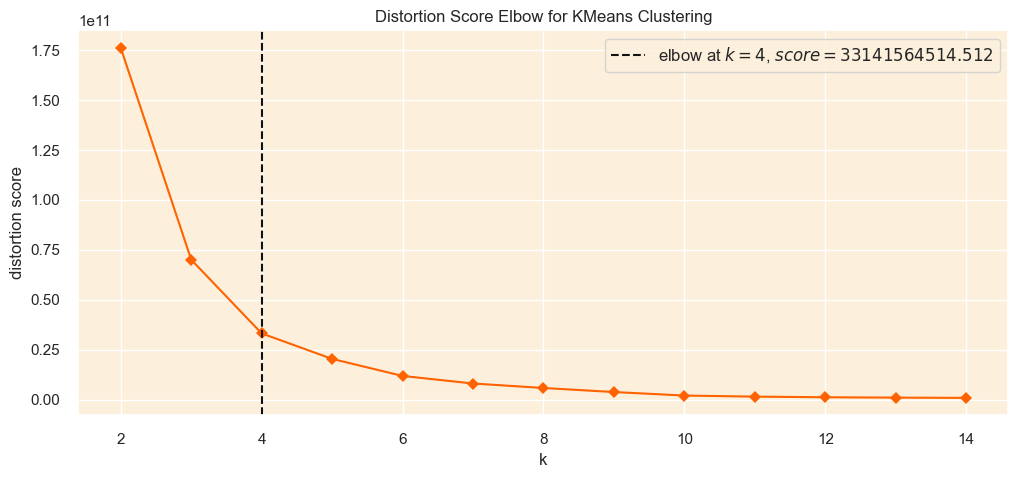

In [38]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(X)

# Finalize and render the figure
visualizer.show();

## Step 2 | Clustering

In [39]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(X)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {3: 2, 2: 1, 1: 0, 0: 3}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
X['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
X['cluster'] = new_labels

In [40]:
# Display the first few rows of the original dataframe
X.head()

,Total_Order_Value,Total_Order_Count,Time_Sine_Last_Order,Average_Order_Value,Product_Diversity,Total_Products_Purchased,Average_Time_Between_Orders,Recent_Product_Category,Geographic,Marketing,Score,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier,cluster
0,0.042644,0.271482,0.989767,-0.082460,0.288856,0.537863,-0.441799,985,78000,0.646078,0.997933,0.107859,-0.334125,-0.028563,1,0,0
1,-1.059871,-0.572965,0.280171,-1.028848,-0.558753,-0.983108,0.380609,677,60528,0.174579,0.932214,-1.039936,-0.968698,-0.023025,1,0,1
2,1.011684,0.834447,-0.581482,0.555379,0.853929,0.659541,-0.614320,1800,75016,3.003573,-1.400807,0.726581,-0.108776,-0.279433,1,0,0
3,-0.486640,-0.572965,0.047017,-0.301770,-0.558753,-0.557236,0.069872,54,97219,0.174579,-0.677899,-0.348319,-0.191107,0.943233,1,0,2
4,-0.393031,0.834447,-0.551071,-0.669554,0.853929,0.172830,-0.973723,236,4179,-0.768419,1.359387,-0.482198,-0.673797,-0.118904,1,0,3


## Step 3 | Clustering Evaluation

In [41]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff', '#ff7c00']

C:\Users\anhdu\AppData\Local\Temp\ipykernel_15292\1657521891.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)


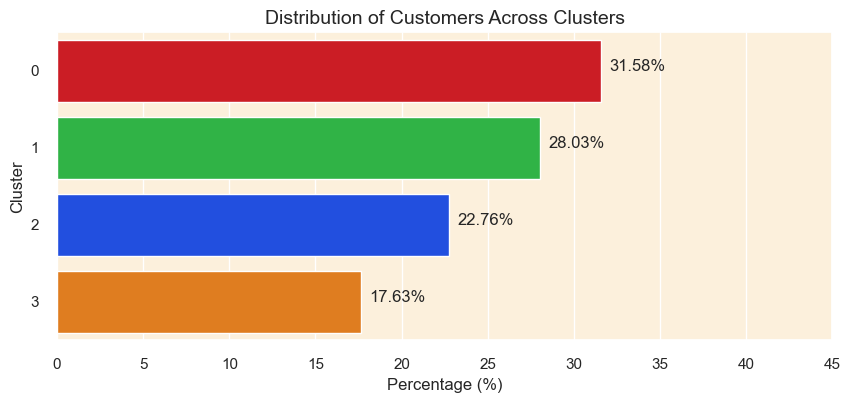

In [42]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (X['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

## Step 4 | Evaluation Metrics

In [43]:
# Compute number of customers
num_observations = len(X)

# Separate the features and the cluster labels
clusters = X['cluster']
X = X.drop('cluster', axis=1)

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |         760         |
|    Silhouette Score     | 0.6561418214156666  |
| Calinski Harabasz Score | 4253.0986459274645  |
|  Davies Bouldin Score   | 0.41670118976252696 |
+-------------------------+---------------------+
